In [8]:
## This notebook is for debugging the test loader for the images which are producing different prediction results with the sam model and parameters but different seed

In [15]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument

import sys
sys.path.insert(0,'..')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


In [16]:
#imports 
import os
import nltk
import spacy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.onnx as onnx
import torch.optim as optim
import torchvision.models as models

from src.baseline.vocabulary import Vocabulary
from src.utils import print_time, list_of_tensors_to_numpy_arr, plot_image, plot_im
from src.accuracy import Accuracy
from src.accuracy import WEIGHT_MAP, WEIGHT_MAP_ONLY_SHIELD_COLOR, WEIGHT_MAP_ONLY_CHARGE, WEIGHT_MAP_ONLY_CHARGE_COLOR
from src.baseline.coa_model import get_new_model,load_model, train_validate_test_split, init_testing_model, test_model, test_rand_image, get_training_mean_std


In [17]:
!export CUDA_VISIBLE_DEVICES=0
!export CUDA_LAUNCH_BLOCKING=1

In [18]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cuda', index=0)

In [19]:
# torch.cuda.get_device_name(0)

In [22]:
# Hyperparams

EXP_FOLDER_PATH = '/home/space/datasets/COA/experiments/' 
run_path   = EXP_FOLDER_PATH + 'run-06-14-2023-09:29:32/'
model_file = 'baseline-model-06-14-2023-16:08:32.pth'
# BATCH_SIZE = 5
NUM_WORKER = 2 #### this needs multi-core
freq_threshold = 5
batch_size = 3


vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, 'head': 8, 'lions': 9, 'cross': 10, 'molxine': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'eagles': 15, 'a': 16, 'b': 17, 'o': 18, 's': 19, 'g': 20, 'e': 21, 'v': 22, '1': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31, '10': 32, '11': 33, 'border': 34, '&': 35}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'lion', 5: 'rampant', 6: 'passt', 7: 'guard', 8: 'head', 9: 'lions', 10: 'cross', 11: 'moline', 12: 'patonce', 13: 'eagle', 14: 'doubleheaded', 15: 'eagles', 16: 'a', 17: 'b', 18: 'o', 19: 's', 20: 'g', 21: 'e', 22: 'v', 23: '1', 24: '2', 25: '3', 26: '4', 27: '5', 28: '6', 29: '7', 30: '8', 31: '9', 32: '10', 33: '11', 34: 'border', 35: '&'}


embed_size=300
vocab_size = 34
attention_dim=256
encoder_dim=512
decoder_dim=512
learning_rate = 0.0009 #0.0005 #0.0004 #0.0001 #3e-4 #0.01 # 
drop_prob=0.5
ignored_idx = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

hyper_params = {'embed_size': embed_size,
                'attention_dim': attention_dim,
                'encoder_dim': encoder_dim,
                'decoder_dim': decoder_dim,
                'vocab_size': vocab_size
              }


In [23]:
data_location =  '/home/salnabulsi/coat-of-arms/data/new/'

root_folder_images = data_location + '/resized'

# test_caption_file = data_location + '/test_captions_faulty.txt'

test_caption_file = data_location + '/test_captions_psumsq.txt'
df = pd.read_csv(test_caption_file)

print("There are {} test images".format(len(df)))

There are 30 test images


In [24]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2

### Get the mean and std 
This was calculated and saved in training phase in files

In [25]:
mean, std = get_training_mean_std(run_path)
mean, std

mean=0.5124953389167786, std=0.3325040936470032


(tensor(0.5125), tensor(0.3325))

### Init the test model

In [26]:
test_loader, test_dataset = init_testing_model(test_caption_file, 
                                               root_folder_images, 
                                               mean, std,
                                               NUM_WORKER,
                                               vocab,
                                               batch_size, 
                                               device, 
                                               pin_memory=False)



In [27]:
dataiter = iter(test_loader)
next(dataiter)

# torch.Size([3, 224, 224]) with crop


(tensor([[[[ 0.8883,  0.8529,  0.8175,  ...,  0.9000,  0.8765,  0.8293],
           [ 0.8647,  0.8411,  0.8057,  ...,  0.8647,  0.8529,  0.8175],
           [ 0.8411,  0.8175,  0.7939,  ...,  0.8293,  0.8293,  0.8057],
           ...,
           [ 0.8883,  0.8765,  0.8647,  ...,  0.9236,  0.9236,  0.9236],
           [ 0.9000,  0.8883,  0.8765,  ...,  0.9118,  0.9118,  0.9118],
           [ 0.9000,  0.8883,  0.8765,  ...,  0.9000,  0.9118,  0.9000]],
 
          [[ 0.7585,  0.7231,  0.6878,  ...,  0.8175,  0.7821,  0.7349],
           [ 0.7349,  0.7113,  0.6760,  ...,  0.7821,  0.7585,  0.7231],
           [ 0.7113,  0.6878,  0.6642,  ...,  0.7467,  0.7349,  0.7113],
           ...,
           [ 0.8411,  0.8293,  0.8175,  ...,  0.8883,  0.8883,  0.8883],
           [ 0.8529,  0.8411,  0.8293,  ...,  0.8765,  0.8765,  0.8765],
           [ 0.8529,  0.8411,  0.8293,  ...,  0.8647,  0.8765,  0.8647]],
 
          [[ 0.5462,  0.5108,  0.4755,  ...,  0.5698,  0.5344,  0.4873],
           [ 

In [31]:
model_path= f"{run_path}/{model_file}"
model, optimizer, loss, criterion = load_model(model_path, 
                                hyper_params, 
                                learning_rate,
                                drop_prob, 
                                ignored_idx,
                                pretrained=True)
model

EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, 

In [ ]:
# test_losses, accuracy_test_list, image_names_list, predictions_list, acc_test_score, test_loss = test_model(model, 
#                                                                         criterion,
#                                                                         test_loader, 
#                                                                         test_dataset, 
#                                                                         vocab_size, 
#                                                                         device,
#                                                                         run_path,
#                                                                         True,
#                                                                         WEIGHT_MAP)    


## Visualizing the attentions

In [151]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#generate caption
def get_caps_from(features_tensors, dataset, device):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps, alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result) 
    for l in range(0, len_result -1):
        temp_att = attention_plot[l].reshape(16,16) 
        
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        
        ax.set_title(result[l])
        
        img = ax.imshow(temp_image)
#         ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        ax.imshow(temp_att, alpha=0.6, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()
    
    #show the tensor image
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
      
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


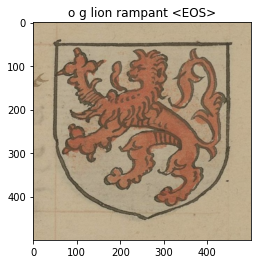

In [152]:
# torch.cuda.empty_cache()
# test_rand_image(model, test_dataset, test_loader, device)

#show any 1
dataiter = iter(test_loader)
images,_,_,_,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, alphas = get_caps_from(img.unsqueeze(0), test_dataset, device)


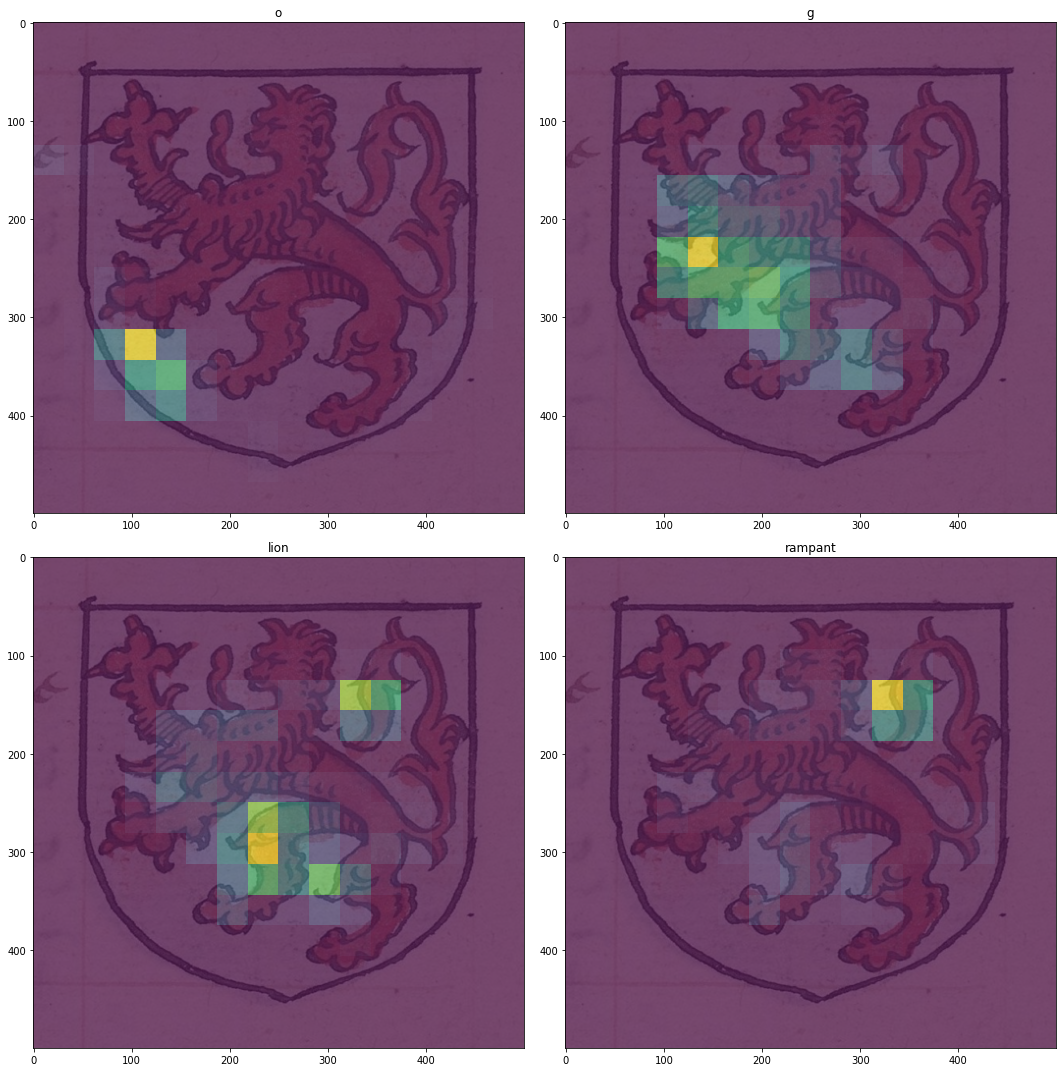

In [153]:
plot_attention(img1, caps, alphas)


In [134]:
type(alphas)

list

In [61]:
len(alphas)

4

In [64]:
type(alphas[0])

numpy.ndarray

In [67]:
len(alphas[0])

1

In [65]:
type(alphas[0][0])

numpy.ndarray

In [68]:
len(alphas[0][0])

256

In [66]:
type(alphas[1][0])

numpy.ndarray

In [70]:
alphas[0].shape

(1, 256)

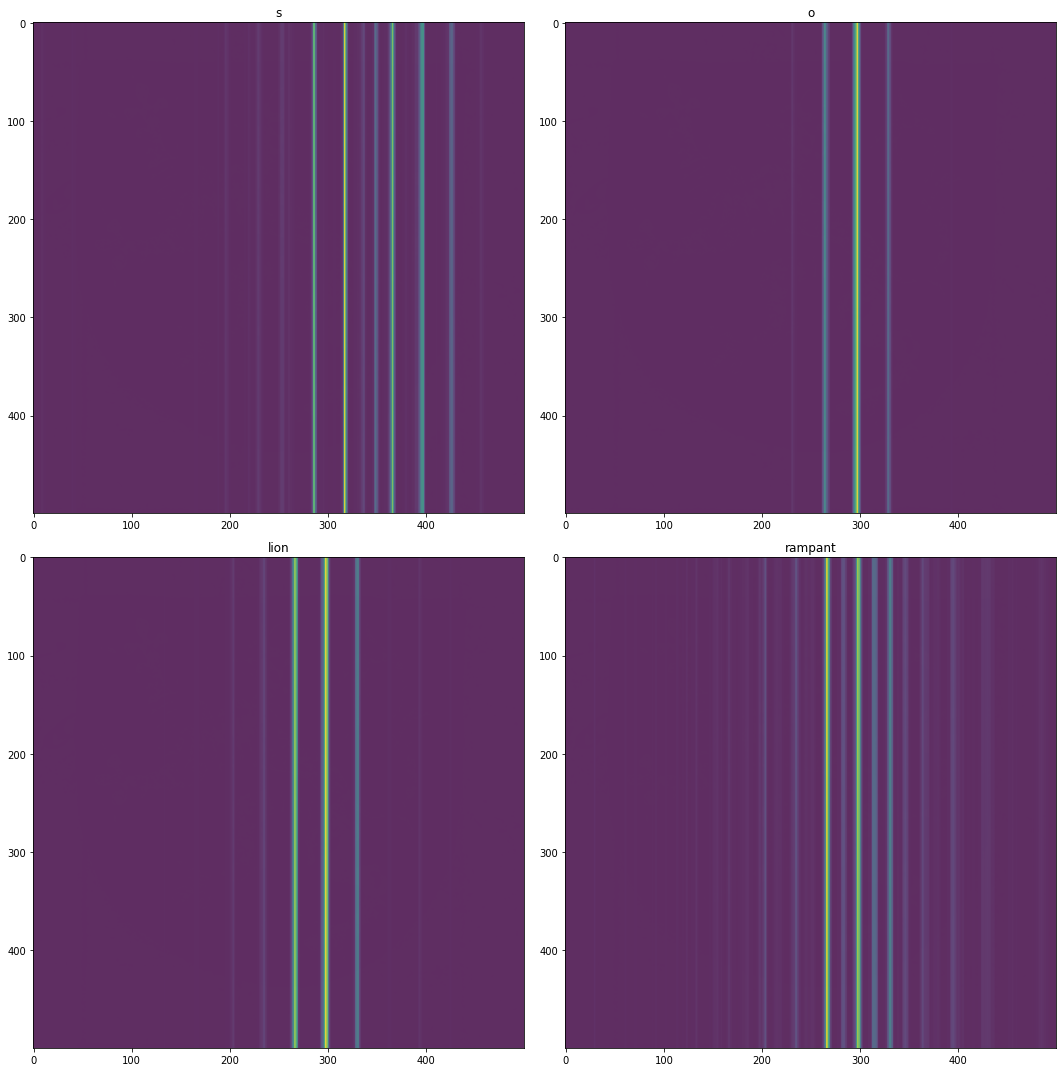

In [94]:

plot_attention(img1, caps, alphas)
